In [1]:
import os
os.chdir('../..')

In [62]:
import numpy as np
import torch

from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from molexplain.utils import MODELS_PATH, PROCESSED_DATA_PATH, DEVICE
from rdkit.Chem import MolFromInchi
from rdkit.Chem import MolFromSmiles
from molexplain.vis import molecule_importance

In [63]:
from molexplain.net import MPNNPredictor

model = MPNNPredictor(node_in_feats=46, edge_in_feats=4, n_tasks=5).to(DEVICE) 


model.load_state_dict(torch.load(os.path.join(MODELS_PATH, "AZ_ChEMBL_MPNN.pt"), map_location=DEVICE))
inchis = np.load(os.path.join(PROCESSED_DATA_PATH, "inchis.npy"))

In [69]:
example_inchi = inchis[666]
print(example_inchi)

InChI=1S/C27H42N4O2/c1-19(28-2)26(32)30-25(21-11-4-3-5-12-21)27(33)29-22-14-9-17-31(18-22)24-16-8-13-20-10-6-7-15-23(20)24/h6-7,10,15,19,21-22,24-25,28H,3-5,8-9,11-14,16-18H2,1-2H3,(H,29,33)(H,30,32)/t19-,22-,24+,25-/m0/s1


In [70]:
mol = MolFromInchi(example_inchi)

In [71]:
svg, atom_importance, edge_importance = molecule_importance(mol, model, task=2, vis_factor=1)

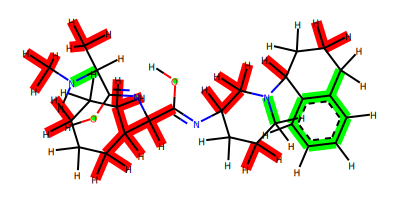

In [72]:
svg

In [68]:
global_importance

array([ 2.1873286e-03,  2.0702055e-03, -3.2900340e-07, -2.8539237e-03,
        2.0839730e-03,  1.5270060e-03, -1.5067457e-03, -1.6960049e-04,
        6.8939215e-07, -1.6960049e-04,  6.8939215e-07,  1.6982256e-05,
        1.6982256e-05,  2.1257943e-03,  2.0860818e-03, -2.8870527e-05,
        3.7027196e-05, -2.5371960e-04, -2.9317345e-04,  2.1581889e-04,
       -1.4154306e-04,  7.8738020e-07, -1.5045828e-03,  1.0893750e-05,
        8.3070842e-04, -7.7359444e-05,  1.5280667e-03, -5.9168984e-04,
        3.0775167e-04, -1.9281784e-05, -1.9272251e-05,  3.0501641e-04,
       -1.9217048e-05,  2.6309019e-04,  2.6309019e-04,  2.6309019e-04,
        2.6309019e-04,  3.1584281e-05,  3.1584281e-05,  3.1584281e-05,
        3.1584281e-05,  3.0491938e-04,  2.4963581e-04,  2.4963581e-04],
      dtype=float32)

In [42]:
symmetric_sm = 'C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=CC=C1'
symmetric_mol = MolFromSmiles(symmetric_sm)

In [49]:
svg, atom_importance, edge_importance = molecule_importance(symmetric_mol, model, n_steps=50, task=1, vis_factor=10, eps=1e-5)

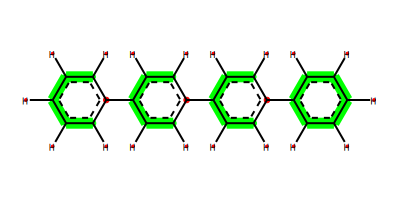

In [50]:
svg

In [15]:
atom_importance

array([ 0.02712379,  0.03049709,  0.00501754,  0.02869753,  0.00478441,
        0.0286651 ,  0.00518763,  0.02573592,  0.0274942 ,  0.02757549,
        0.02734781,  0.02644007,  0.0271069 ,  0.02642267,  0.02709866,
        0.026404  ,  0.02735788,  0.02763591, -0.01263671, -0.01264908,
       -0.01267475, -0.01267481, -0.01266199, -0.01263786, -0.01263679,
       -0.01264908, -0.01266188, -0.01266188, -0.01264906, -0.0126367 ],
      dtype=float32)

In [20]:
global_importance

array([-0.00529573,  0.00171669, -0.04053302, -0.01640747], dtype=float32)